In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import sys
sys.path.insert(1, '../../../torch-helper')
from pthelper.utils import DataLoaderWrapper
from pthelper.training import ModelWrapper
from pthelper.vision import predict

# Dataset Study

In [2]:
train_images = [x for x in os.listdir('train') if x.endswith('.jpg')]
train_images

['23c088f6ec27_14.jpg',
 'f8b6f4c39204_07.jpg',
 '87e334269396_05.jpg',
 'b24fd9084449_01.jpg',
 'fc5f1a3a66cf_01.jpg',
 '0d53224da2b7_14.jpg',
 'f98dbe8a5ee2_05.jpg',
 '9274d0b3caa8_04.jpg',
 '4e7bc95552ed_16.jpg',
 'd1a3af34e674_05.jpg',
 '64f701f36437_16.jpg',
 'c53e374fdd72_10.jpg',
 '424658d9f222_11.jpg',
 '1a17a1bd648b_04.jpg',
 '3bca821c8c41_10.jpg',
 '3afec4b5ac07_10.jpg',
 'fd9da5d0bb6f_03.jpg',
 '5bc30efeb7bf_15.jpg',
 '1952e5f91de0_10.jpg',
 '16f0ec26d608_04.jpg',
 'de74550a306a_04.jpg',
 '0d1a9caf4350_06.jpg',
 'fc237174b128_03.jpg',
 '08a646be6b30_07.jpg',
 'dd47eb7ac4ee_01.jpg',
 '7251c8797749_02.jpg',
 'c7a94c46a3b2_16.jpg',
 'b63a6f7952d4_07.jpg',
 '40851e617b93_13.jpg',
 'd0dab700c896_04.jpg',
 'c4f1840b2a65_06.jpg',
 '6f6dced498c4_10.jpg',
 '3810c5e1cdeb_16.jpg',
 'eefc0d8c94f0_09.jpg',
 'ebfdf6ec7ede_09.jpg',
 '21a7e6726ee3_05.jpg',
 '6e016b8b3617_09.jpg',
 'd0dab700c896_05.jpg',
 '6cc98271f4dd_11.jpg',
 'c2fd64144e97_06.jpg',
 'cf65b1c5e147_15.jpg',
 '6d77433cc7ce_1

Each image name is of the format 'carid_carnumber.jpg', where carid is a different car and carnumber is one car image of type carid.

In [3]:
train_images = [x.split('_')[0] for x in os.listdir('train') if x.endswith('.jpg')]
carid_list = set(train_images)
print('Total no. of images -', len(train_images))
print('Total no. of non duplicate images -', len(carid_list))
print('Approx. no. of images per car -', len(train_images)/len(carid_list))

Total no. of images - 5088
Total no. of non duplicate images - 318
Approx. no. of images per car - 16.0


So, for each car we have around 16 different images. Next let us look at some of the images.

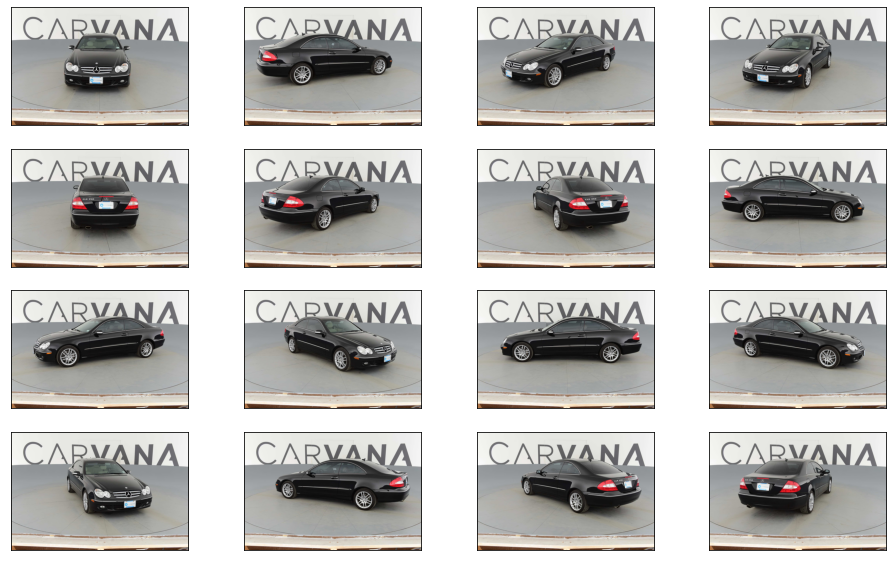

In [4]:
car_image_list = [x for x in os.listdir('train') if x.startswith('b24fd9084449')]
fig = plt.figure(figsize=(16, 10))
for i, car_image in enumerate(car_image_list):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(plt.imread('train/'+car_image))
    plt.xticks([])
    plt.yticks([])
plt.show()

Let us look at each image along with its mask.<br>
Note: All masks are gif type (while train images are jpg type). Also mask image names have an extra "_mask" string in the filname.

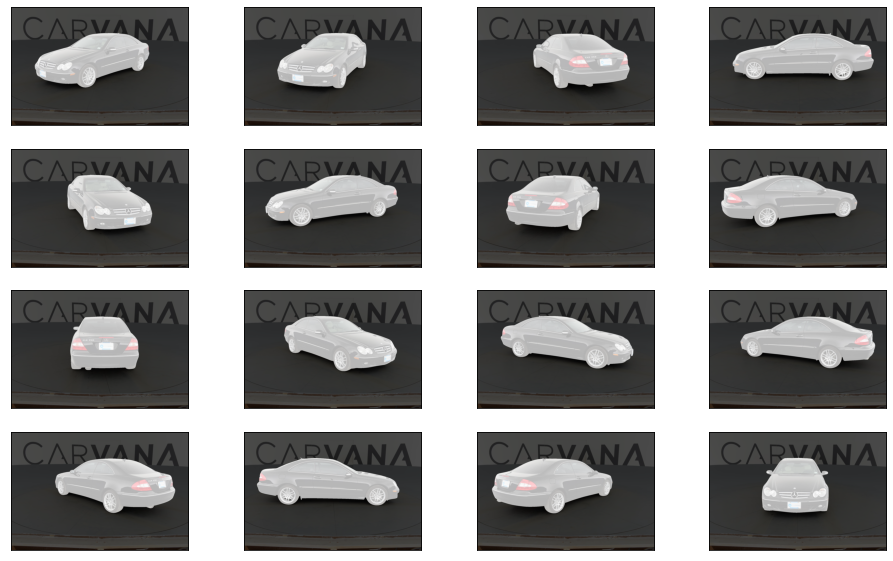

In [5]:
car_mask_list = [x for x in os.listdir('train_masks') if x.startswith('b24fd9084449')]
fig = plt.figure(figsize=(16, 10))
for i, car_mask in enumerate(car_mask_list):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(plt.imread('train/'+car_mask.replace('_mask', '').replace('gif', 'jpg'))) 
    plt.imshow(plt.imread('train_masks/'+car_mask), cmap='jet', alpha=0.7)
    plt.xticks([])
    plt.yticks([])
plt.show()

# Create Dataset

In [6]:
batch_size = 16
new_image_size = (100, 100)

In [7]:
def random_split(root_dir, val_pct=0.2):
    train_set = []
    val_set = []
    for carid in carid_list:
        image_set = [img for img in os.listdir(root_dir) if img.startswith(carid)]
        random.shuffle(image_set)
        
        val_size = round(len(image_set) * val_pct)
        
        train_set += image_set[val_size:]
        val_set += image_set[:val_size]
    
    return train_set, val_set

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_set, image_dir, mask_dir, train=True):
        self.image_set = image_set
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.train = train
        
    def __len__(self):
        return len(self.image_set)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.image_dir, self.image_set[index]))
        img_mask = Image.open(os.path.join(self.mask_dir, self.image_set[index].replace('.jpg', '_mask.gif'))).convert('L')
        
        # Transformation
        img = transforms.Resize(new_image_size)(img)
        img_mask = transforms.Resize(new_image_size)(img_mask)
        
        if self.train:
            if random.random() > 0.5:
                img = TF.hflip(img)
                img_mask = TF.hflip(img_mask)

            if random.random() > 0.5:
                img = TF.vflip(img)
                img_mask = TF.vflip(img_mask)
        
        img = transforms.ToTensor()(img)
        img_mask = transforms.ToTensor()(img_mask)
        
        return img, img_mask.view(-1)

In [9]:
train_set, val_set = random_split('train')
train_dataset = ImageDataset(train_set, 'train', 'train_masks')
val_dataset = ImageDataset(val_set, 'train', 'train_masks')

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_dataset, batch_size=batch_size*2)

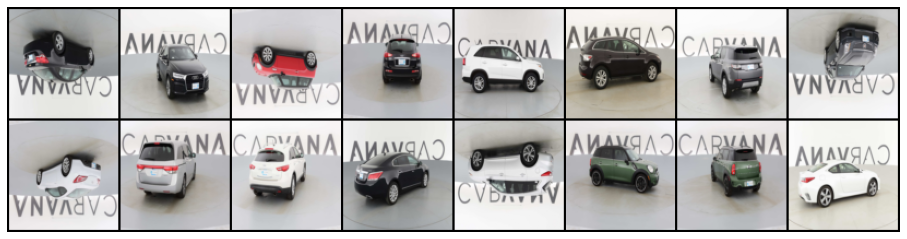

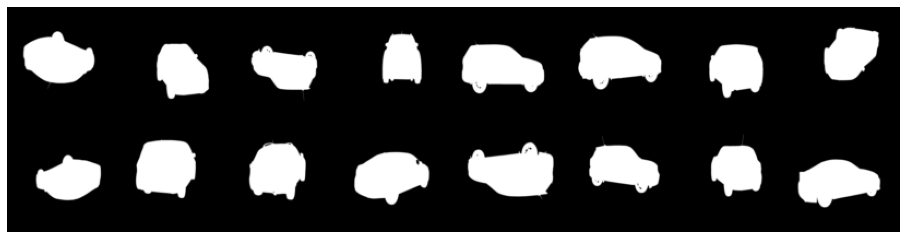

In [10]:
for batch in train_dl:
    xb, yb = batch
    plt.figure(figsize=(16, 10))
    plt.imshow(make_grid(xb, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(16, 10))
    plt.imshow(make_grid(yb.view(-1, 1, new_image_size[0], new_image_size[1]), nrow=8).permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    break

In [11]:
train_dl = DataLoaderWrapper(train_dl)
val_dl = DataLoaderWrapper(val_dl)

# Create Model

In [12]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
#             nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2),
            nn.ReLU()
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [13]:
model = CustomModel()
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()
model = ModelWrapper(model, opt, criterion, pred_func=nn.Sigmoid(), output_selection_func='round')

In [14]:
model.fit(5, train_dl, val_dl)

epoch -> 1    lr -> 0.005000    train loss -> 0.675288    train acc -> 0.814428    val loss -> 0.658638    val acc -> 0.848819
epoch -> 2    lr -> 0.005000    train loss -> 0.667223    train acc -> 0.827958    val loss -> 0.646830    val acc -> 0.867945
epoch -> 3    lr -> 0.005000    train loss -> 0.640310    train acc -> 0.872129    val loss -> 0.628793    val acc -> 0.888310
epoch -> 4    lr -> 0.005000    train loss -> 0.627626    train acc -> 0.887603    val loss -> 0.621694    val acc -> 0.895212
epoch -> 5    lr -> 0.005000    train loss -> 0.633074    train acc -> 0.879952    val loss -> 0.628188    val acc -> 0.888237


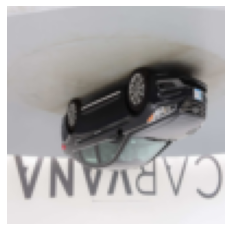

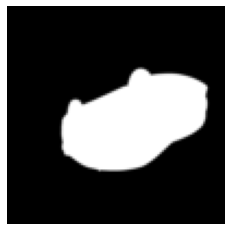

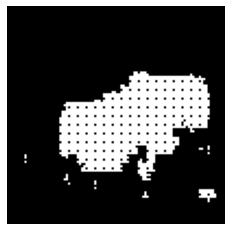

In [37]:
image, mask = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.xlabel('Input Image')
plt.show()
plt.imshow(mask.view(100, 100), cmap='gray')
plt.axis('off')
plt.xlabel('Input Mask')
plt.show()
_, pred, _ = predict(model, image)
pred = pred.squeeze()
plt.imshow(pred, cmap='gray')
plt.axis('off')
plt.xlabel('Predicted Mask')
plt.show()

In [28]:
pred.permute(1, 2, 0).shape

torch.Size([100, 100, 1])

In [27]:
train_dataset[0][0].permute(1, 2, 0).shape

torch.Size([100, 100, 3])